In [7]:
#Import statments

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pandas.tseries.offsets import DateOffset

In [2]:
#uploading the dataframe

df1 = pd.read_csv('/content/idx_cleanded_data1.csv')
df2 = pd.read_csv('/content/idx_cleanded_data2.csv')
df3 = pd.read_csv('/content/idx_cleanded_data3.csv')

/tmp/ipython-input-1142530645.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/idx_cleanded_data2.csv')
/tmp/ipython-input-1142530645.py:3: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/content/idx_cleanded_data3.csv')


In [3]:
df = pd.merge(df1, df2, how = 'outer')
df = pd.merge(df, df3, how='outer')

In [4]:
#removing any potential outliers within the ClosePrice variable

Q1 = df['ClosePrice'].quantile(0.005)
Q3 = df['ClosePrice'].quantile(0.995)


df = df[(df['ClosePrice'] >= Q1) & (df['ClosePrice'] <= Q3)]

In [5]:
#Creating the train/test split

df['CloseDate'] = pd.to_datetime(df['CloseDate'], yearfirst=True);

last_date = df['CloseDate'].max();
test_date = last_date-DateOffset(months=1);
train_date = test_date-DateOffset(months=6);

train_df = df[(df['CloseDate'] > train_date) & (df['CloseDate'] < test_date)];
test_df = df[(df['CloseDate'] >= test_date)];
test_df = test_df[(test_df['ClosePrice'] > test_df['ClosePrice'].quantile(0.05)) & (test_df['ClosePrice'] < test_df['ClosePrice'].quantile(0.95))]

train_y = train_df['ClosePrice'];
test_y = test_df['ClosePrice'];

In [8]:
#Dropping some colums to improve the df
drop_cols = ['Flooring', 'Levels', 'UnparsedAddress', 'PostalCode', 'City', 'StreetNumberNumeric', 'PropertyType', 'PropertySubType', 'ClosePrice', 'CloseDate', 'DaysOnMarket', 'BuyerOfficeName', 'BuyerAgentMlsId', 'BuyerAgentFirstName', 'BuyerAgentLastName', 'BuyerAgentAOR', 'BuyerOfficeAOR', 'ContractStatusChangeDate', 'PurchaseContractDate', 'MLSAreaMajor', 'CountyOrParish', 'ElementarySchool', 'SubdivisionName', 'ListingContractDate', 'HighSchool', 'HighSchoolDistrict', 'StateOrProvince', 'MiddleOrJuniorSchool'];
train_X = train_df.drop(columns=drop_cols);
test_X = test_df.drop(columns=drop_cols);

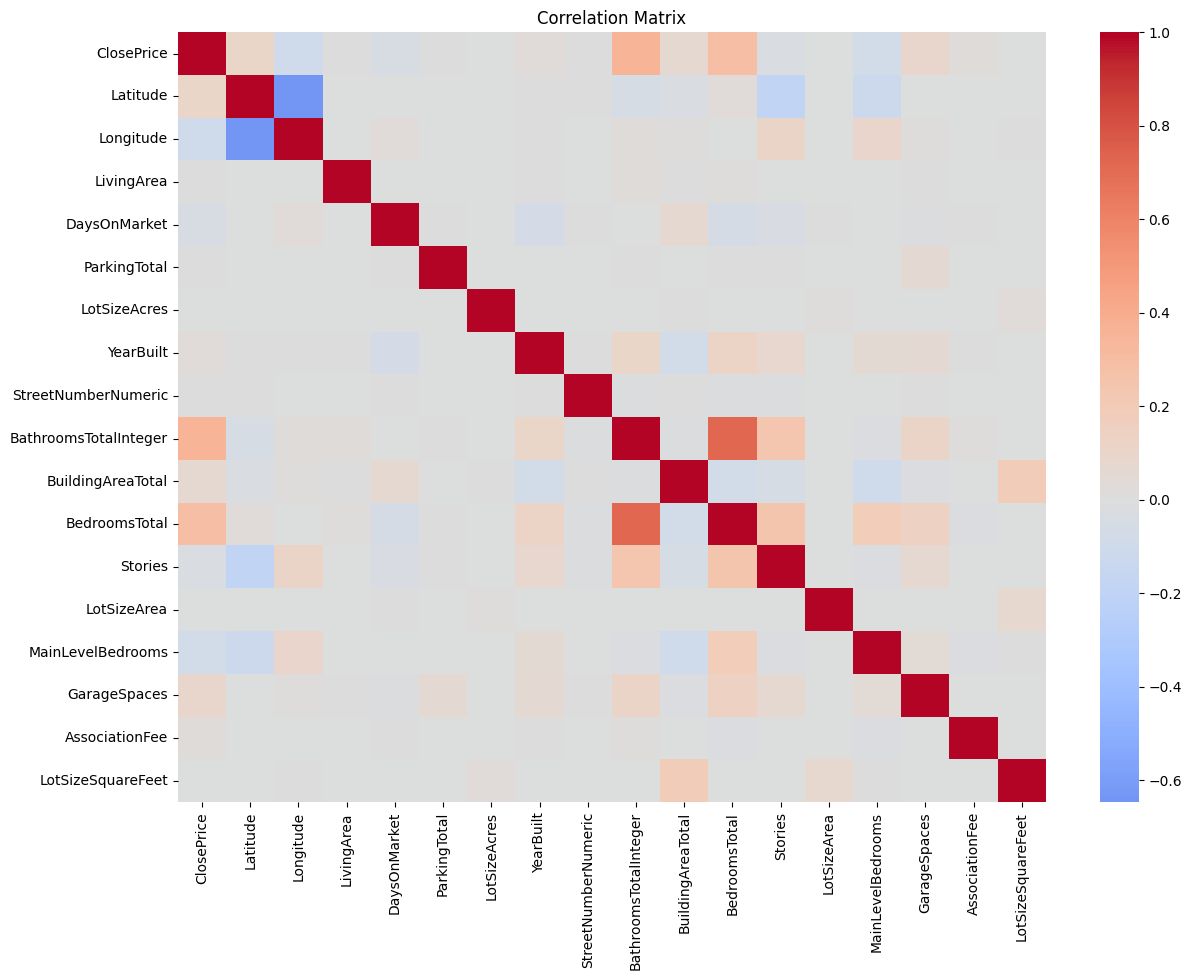

In [9]:
#Building the correlation matrix
corr_matrix = df.select_dtypes(include='number').corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [10]:
#Creating a function to complete forward selection on the dataframe

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def forward_selection(df, target_col, metric='r2', cv=5):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X = pd.get_dummies(X, drop_first=True)

    remaining = list(X.columns)
    selected = []
    results = []
    best_overall_score = -np.inf

    model = LinearRegression()

    for step in range(len(remaining)):
        best_score = -np.inf
        best_feature = None

        for feature in remaining:
            candidate = selected + [feature]
            cv_scores = cross_val_score(
                model, X[candidate], y,
                cv=cv, scoring='r2'
            )
            score = cv_scores.mean()

            if score > best_score:
                best_score = score
                best_feature = feature

        if best_score <= best_overall_score:
            print(f"Stopping early at step {step+1} — no improvement found.")
            break

        selected.append(best_feature)
        remaining.remove(best_feature)
        best_overall_score = best_score

        results.append({
            'step': step + 1,
            'feature_added': best_feature,
            'cv_r2': round(best_score, 4),
            'features_so_far': selected.copy()
        })

        print(f"Step {step+1}: Added '{best_feature}' | CV R² = {best_score:.4f}")

    results_df = pd.DataFrame(results)
    return selected, results_df

In [28]:
#Using numeric colums due to issues using the model with categorical columns
num_cols = train_df.select_dtypes(include='number').columns
train_df = train_df[num_cols]

In [29]:
#Setting the x and y for the model

X = train_df.drop(columns=['ClosePrice'])
y = train_df['ClosePrice']

In [35]:
#Running the forward selection function on the training data
selected_features, results_df = forward_selection(train_df, target_col='ClosePrice')

final_df = selected_features
print("Final 5 features:", final_df)

Step 1: Added 'BathroomsTotalInteger' | CV R² = 0.0899
Step 2: Added 'Longitude' | CV R² = 0.0966
Step 3: Added 'MainLevelBedrooms' | CV R² = 0.1000
Step 4: Added 'BedroomsTotal' | CV R² = 0.1050
Step 5: Added 'Stories' | CV R² = 0.1103
Step 6: Added 'GarageSpaces' | CV R² = 0.1113
Step 7: Added 'DaysOnMarket' | CV R² = 0.1122
Stopping early at step 8 — no improvement found.
Final 5 features: ['BathroomsTotalInteger', 'Longitude', 'MainLevelBedrooms', 'BedroomsTotal', 'Stories', 'GarageSpaces', 'DaysOnMarket']


In [36]:
#Building a simple tree model to evaluate the df
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score

X_train = train_df.drop(columns = ['ClosePrice'])
X_train = train_df[num_cols]
y_train = train_df['ClosePrice']

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)


# Evaluate
y_test = test_df['ClosePrice']
y_pred = tree.predict(test_df[num_cols])

print(f"R²: {r2_score(y_test, y_pred):.4f}")
#print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")

R²: 1.0000
